In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import matplotlib.pyplot as plt
import latent_plot as lp
from torch.autograd import Variable
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from data_loader import FundusDataLoader

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
csv_path = '/home/vip/sayan-mandal/datasets/obj_criteria/20200619-objective.csv'
img_path = '/home/vip/sayan-mandal/datasets/obj_criteria/good_reduced/'

FD = FundusDataLoader(csv_path, img_path,transform=transforms.Compose([transforms.Resize(224), transforms.ToTensor()]))

#random sampler
batch_size = 64
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(FD)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(FD, batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(FD, batch_size=batch_size, sampler=valid_sampler)


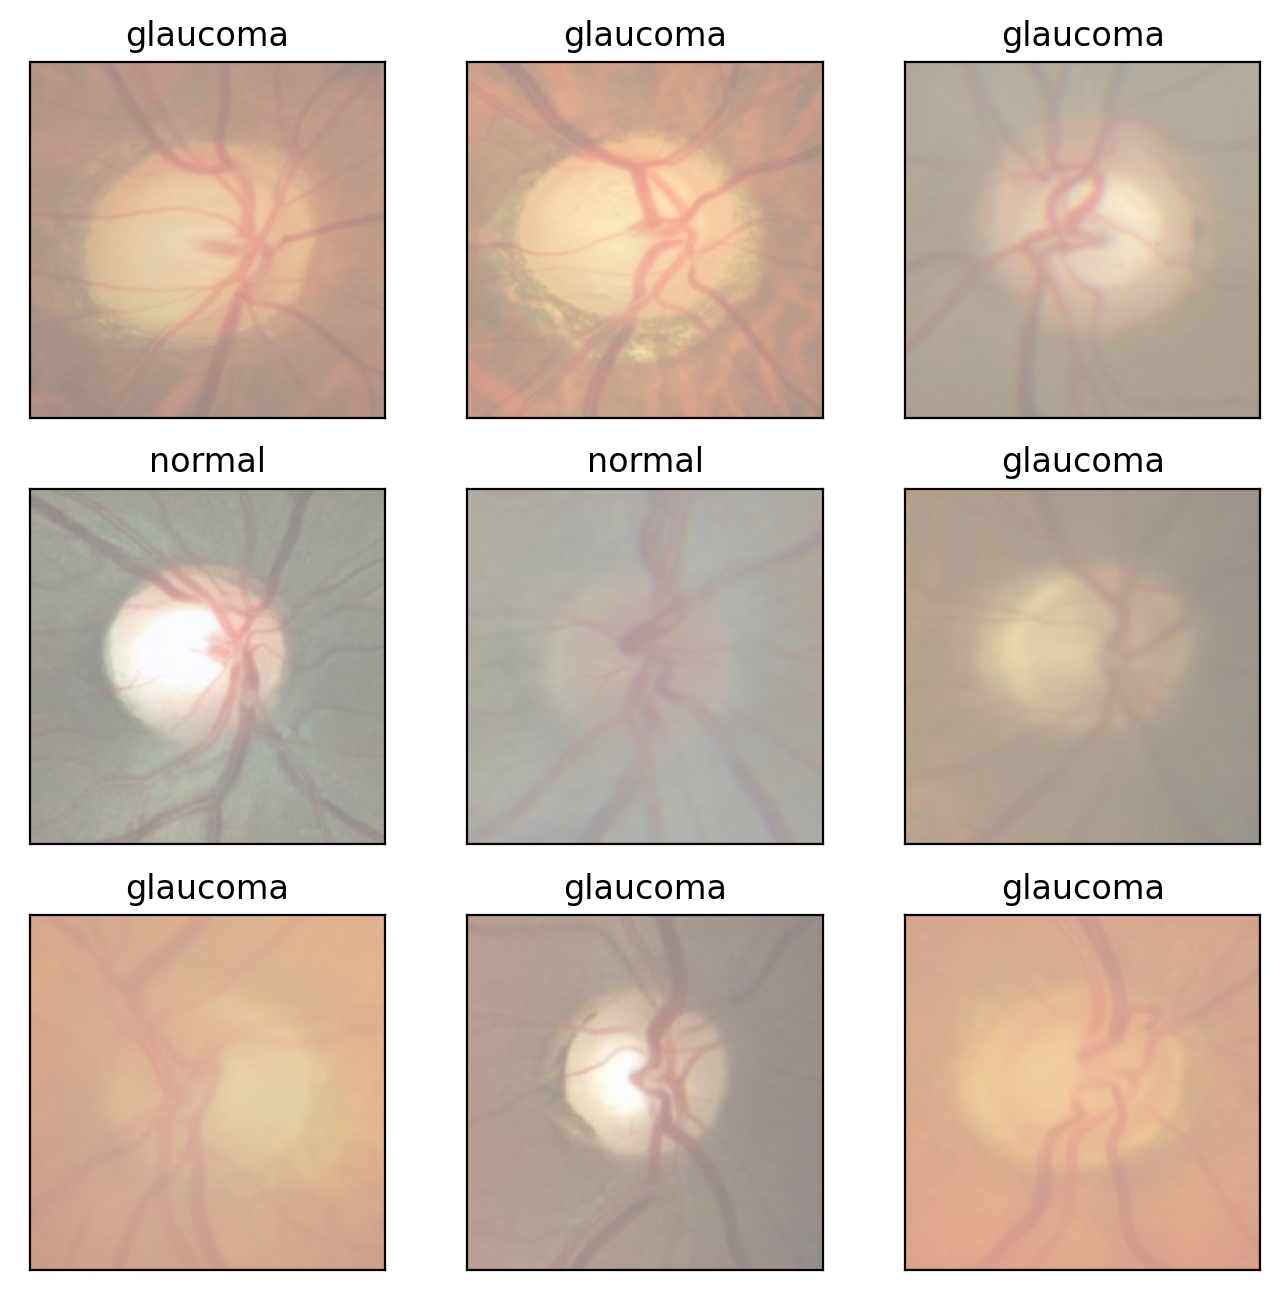

In [4]:
#Utility functions to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0))) 

 
#Define the image classes
classes = ['normal','glaucoma']

#Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

#Plot the images
fig = plt.figure(figsize=(8, 8))
# display 20 images
for idx in np.arange(9):
    ax = fig.add_subplot(3, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [5]:
#kl divergence loss
#lossfunc = F.mse_loss(y,x)

def criterion(y, x, mu, logvar):
    # recontruction loss
    recon = F.binary_cross_entropy(y,data)
    # kl divergence between Q(z|x) ~ N(mu, sigma) and P(z) ~ N(0, I)
    kl = -0.5*torch.mean(1+logvar-mu.pow(2) - logvar.exp()).mean()
    return recon + 0.01*kl, recon, kl

In [6]:
class VAE(nn.Module):
    def __init__(self, in_shape, n_latent):
        super().__init__()
        self.in_shape = in_shape
        self.n_latent = n_latent
        c,h,w = in_shape
        self.z_dim = h//2**2 # receptive field downsampled 2 times
        self.encoder = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=4, stride=2, padding=1),  # 32, 112, 112
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 64, 56, 56
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 128, 28, 28
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc1 = nn.Linear(128 * 28**2, n_latent)
        self.fc2 = nn.Linear(128 * 28**2, n_latent)
        self.fc3 = nn.Linear(n_latent, 128 * 28**2)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def sample_z(self, mean, logvar):
        stddev = logvar.mul(0.5).cuda()
        noise = Variable(torch.randn(*mean.size())).cuda()
        return (noise * stddev) + mean

    def bottleneck(self, h):
        mean, logvar = self.fc1(h), self.fc2(h)
        z = self.sample_z(mean, logvar)
        return z, mean, logvar

    def encode(self, x):
        x = self.encoder(x)
        z, mean, logvar = self.bottleneck(x)
        return z, mean, logvar

    def decode(self, z):
        out = self.fc3(z)
        out = out.view(out.shape[0], 128, 28, 28)
        out = self.decoder(out)
        return out

    def forward(self, x):
        z,mean, logvar = self.encode(x)
        out = self.decode(z)
        return out, mean, logvar


#Instantiate the model
model = VAE((3,224,224),2).cuda()
print(model)

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=100352, out_features=2, bias=True)
  (fc2): Linear(in_features=100352, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=100352, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 10
ep,lss,kll,bcel = [],[],[],[]
for e in range(epochs):
    print('Start training.')
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data).cuda()
        optimizer.zero_grad()
        y, mu, sig = model(data) # y = reconstructed image
        loss,bce,kld = criterion(y, data, mu, sig)
        loss.backward()
        optimizer.step()
        to_print = "Epoch[{}/{}] - Batch: {}, Loss: {:.3f} {:.3f} {:.3f}".format(e+1, 
                                epochs, batch_idx, loss.item(), bce.item(), kld.item())
        print(to_print)
    ep += [e]
    lss += [loss.item()]
    kll += [kld.item()]
    bcel += [bce.item()]

10] - Batch: 35, Loss: 1.420 0.571 84.868
Epoch[7/10] - Batch: 36, Loss: 1.478 0.581 89.740
Epoch[7/10] - Batch: 37, Loss: 1.481 0.574 90.737
Epoch[7/10] - Batch: 38, Loss: 1.424 0.561 86.209
Epoch[7/10] - Batch: 39, Loss: 1.407 0.566 84.055
Epoch[7/10] - Batch: 40, Loss: 1.450 0.580 86.907
Epoch[7/10] - Batch: 41, Loss: 1.438 0.573 86.487
Epoch[7/10] - Batch: 42, Loss: 1.421 0.577 84.341
Epoch[7/10] - Batch: 43, Loss: 1.412 0.566 84.572
Epoch[7/10] - Batch: 44, Loss: 1.406 0.562 84.404
Epoch[7/10] - Batch: 45, Loss: 1.411 0.580 83.073
Epoch[7/10] - Batch: 46, Loss: 1.402 0.553 84.924
Epoch[7/10] - Batch: 47, Loss: 1.399 0.554 84.487
Epoch[7/10] - Batch: 48, Loss: 1.451 0.578 87.358
Epoch[7/10] - Batch: 49, Loss: 1.431 0.571 85.956
Epoch[7/10] - Batch: 50, Loss: 1.427 0.585 84.180
Epoch[7/10] - Batch: 51, Loss: 1.382 0.560 82.252
Epoch[7/10] - Batch: 52, Loss: 1.432 0.569 86.344
Epoch[7/10] - Batch: 53, Loss: 1.447 0.582 86.488
Epoch[7/10] - Batch: 54, Loss: 1.429 0.581 84.778
Epoch[7/

In [8]:
torch.save(model.state_dict(), 'vae.torch')

In [7]:
from latent_plot import latent_space_representation
model = VAE((3,224,224),2)
model.load_state_dict(torch.load('vae.torch'))
latent_space_representation(20,(-10,10),model)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [128, 64, 3, 3], but got 1-dimensional input of size [2] instead

In [22]:
y, mu, sig = model(data)

RuntimeError: cuDNN error: CUDNN_STATUS_MAPPING_ERROR

In [15]:
criterion(y,data,mu,sig)[0].item()

2.7112386683944787e+29

In [14]:
-0.5*torch.mean(1+sig-mu.pow(2) - sig.exp())

tensor(0.1601, device='cuda:0', grad_fn=<MulBackward0>)

In [10]:
mu

tensor([[-1.0006,  0.7224],
        [-0.2859,  0.3265],
        [-0.4110,  0.1708],
        [-0.5590,  0.2732],
        [-0.2082,  0.2209],
        [ 0.0441,  0.1317],
        [-0.2259,  0.4890],
        [-0.6062,  0.4695],
        [-0.3435,  0.3804],
        [-0.5347,  0.0900],
        [-0.6377,  0.9612],
        [-1.3148,  0.8757],
        [-0.7160,  0.0289],
        [-1.2047,  0.1833],
        [-0.3074,  0.2192],
        [ 0.2301, -0.1184],
        [-0.4479,  0.0399],
        [-0.2342, -0.0435],
        [-0.6142,  0.8199],
        [-0.3416,  0.3371],
        [-0.2117,  0.6165],
        [-0.1779,  0.0176],
        [-0.1792,  0.1361],
        [-0.0693,  0.2698],
        [-0.5203,  0.8919],
        [-0.2120,  0.2071],
        [-1.3174,  0.7760],
        [-0.2692,  0.0051],
        [-0.5470,  0.5002],
        [ 0.0451, -0.1493],
        [-0.1421,  0.2545],
        [-0.1464,  0.5295],
        [-0.2237,  0.7497],
        [-1.1224,  0.6833],
        [-0.0929,  0.6361],
        [-0.3632,  0

In [13]:
mu.shape

torch.Size([64, 2])

In [17]:
y.shape[0]/2

32.0